In [3]:
import numpy as np
import matplotlib.pyplot as plt
from build_FDTD import build_FDTD
from build_FDTD import build_crystal

The goal is to create a photonic crystal for each individual mode exiting the multimodal fiber

In [2]:
fdtd = build_FDTD(lumerical_name= 'test', injection_angle=-11.5)

In [4]:
RING = {
    "inner_radius": 0.9384,  # [um]
    "outer_radius": 1.3432,  # [um]
    "depth": 0.070,  # [um]
    "matname": "etch"
}

In [5]:
fdtd.select("FDTD::ports::input_port")
fdtd.set("mode selection", "user select")
fdtd.set("selected mode numbers", 1)

In [6]:
# calculate grating pitch
lambda0 = 1.55  # [um]
ff = 0.6
n_etch = 1.2 # TE0
n_wg =  1.65433 # TE0
n_eff = n_wg*ff + n_etch*(1-ff)
n_clad = 1
theta = -11.5
# bc of snellius the angle in the air is different as in the fiber
theta_air = np.arcsin(1.444*np.sin(np.deg2rad(theta)/1))
theta_air = np.rad2deg(theta_air)
print(theta_air)
                      
# get pitch
pitch = lambda0/(n_eff - n_clad*np.sin(np.deg2rad(theta_air)))
print("pitch = ", pitch)

CIRCLE = {
    "radius": ((1-ff)*pitch)/2,  # [um]
    "depth": 0.33,  # [um]
    "matname": "etch"
}

-16.73151378953476
pitch =  0.8804390484706491


In [7]:
crystal_args = {
    "dimension": 70,
    
    "crystal_constant": pitch,
    "scatterer": "CIRCLE",
    "scatterer_kwargs": CIRCLE,
    "matname": "etch",
}
build_crystal(fdtd, **crystal_args)

In [23]:
pitch = np.linspace(0.82, 0.95, num=14, endpoint=True)
transmissions = []
# now do a sweep over the period for the fundamental mode
for p in pitch:
    # switch to layout mode
    fdtd.switchtolayout()
    #build crystal
    CIRCLE = {
        "radius": ((1-ff)*p)/2,  # [um]
        "depth": 0.33,  # [um]
        "matname": "etch"
    }
    crystal_args = {
        "dimension": 70,
        "crystal_constant": p,
        "scatterer": "CIRCLE",
        "scatterer_kwargs": CIRCLE,
        "matname": "etch",
    }
    # build into fdtd
    build_crystal(fdtd, **crystal_args)
    # run simulation
    fdtd.run()
    # get transmission
    t = (max(fdtd.transmission("monitor_1")) + 
                    max(fdtd.transmission("monitor_2")))
    transmissions.append(t)

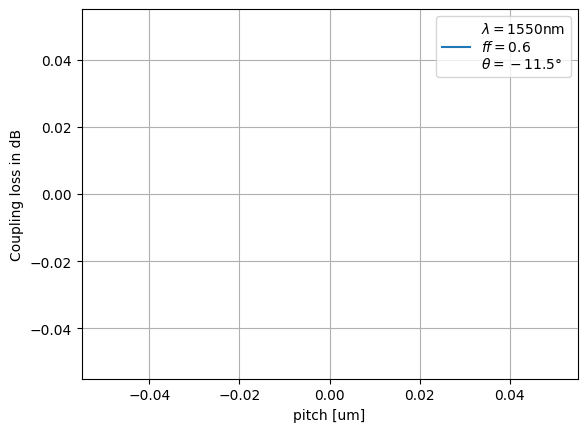

In [34]:
# convert transmission to dB loss
transmissions_dB = 10*np.log10(transmissions)
plt.plot(pitch, transmissions_dB, 
         label = r"$\lambda = 1550$nm" + '\n' + r"$ff=0.6$" + '\n' + r'$\theta = -11.5\degree$')
plt.xlabel("pitch [um]")
plt.ylabel("Coupling loss in dB")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [22]:
fdtd.switchtolayout()
fdtd.select("FDTD::ports::input_port")
fdtd.set("mode selection", "user select")
fdtd.set("selected mode numbers", 1)

In [ ]:
# let's do this whole calculation again for the first five modes
modes = [1, 3, 5, 7, 9]
pitch = np.linspace(0.82, 0.95, num=15, endpoint=True)
# initialize transmission matrix
transmissions_extensive = np.zeros((len(modes), len(pitch)))
# now do a sweep over the period for the different modes
for m in modes:
    # switch to layout mode
    fdtd.switchtolayout()
    # set mode
    fdtd.select("FDTD::ports::input_port")
    fdtd.set("mode selection", "user select")
    fdtd.set("selected mode numbers", m)
    for p in pitch:
        # switch to layout mode
        fdtd.switchtolayout()
        #build crystal
        CIRCLE = {
            "radius": ((1-ff)*p)/2,  # [um]
            "depth": 0.33,  # [um]
            "matname": "etch"
        }
        crystal_args = {
            "dimension": 70,
            "crystal_constant": p,
            "scatterer": "CIRCLE",
            "scatterer_kwargs": CIRCLE,
            "matname": "etch",
        }
        # build into fdtd
        build_crystal(fdtd, **crystal_args)
        # run simulation
        fdtd.run()
        # get transmission
        t = (max(fdtd.transmission("monitor_1")) + 
                        max(fdtd.transmission("monitor_2")))
        transmissions_extensive[modes.index(m), pitch.index(p)] = t